# Microstructure Image Segmentation Tutorial

This notebook gives a quick tutorial to perform image segmentation of ultra-high carbon steel (UHCS) microstructure images using deep learning. The notebook is designed for running on Google Colab to use GPUs for computing. Click the button below to run the notebook on Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/holmgroup/img-segmentation/blob/main/img_seg_tutorial.ipynb)


## Setup

In [1]:
# Connect git repo to colab, install package
!git clone https://github.com/holmgroup/img-segmentation.git
!pip install segmentation-models-pytorch --quiet
%cd img-segmentation

Cloning into 'img-segmentation'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 73 (delta 28), reused 67 (delta 25), pack-reused 0
Unpacking objects: 100% (73/73), done.
     |████████████████████████████████| 88 kB 2.2 MB/s 
     |████████████████████████████████| 58 kB 970 kB/s 
     |████████████████████████████████| 376 kB 10.2 MB/s 
/content/img-segmentation


In [2]:
import os
import numpy as np
import imageio
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp

Make sure GPU is used for computation. If `torch.cuda.is_available()` is `False`, go to Runtime -> Change runtime type and select GPU.

In [3]:
torch.cuda.is_available()

True

## Dataset

UHCS segmentation dataset contains 24 images. In this tutorial, 16 images are used for training, 4 images for model validation and the rest 4 for test. The image names in each subset can be found in `./data/split/*.txt`.

In [4]:
class DatasetTextSplit(Dataset):
    def __init__(self, root, split_file, size): 
        self.img_dir, self.label_dir = f'{root}/images', f'{root}/labels_npy'
        self.img_names = np.loadtxt(f'{root}/split/{split_file}',
                                    dtype=str, delimiter='\n', ndmin=1)
        self.transform_label = T.Compose([
            T.Resize(size),
            T.ToTensor()
        ]) 
        self.transform_img = T.Compose([
            self.transform_label,
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img_path = f'{self.img_dir}/{img_name}'
        label_path = f'{self.label_dir}/{os.path.splitext(img_name)[0]}.npy'
        with open(img_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
            img = self.transform_img(img)
        label = np.load(label_path).astype(np.int8)
        label = Image.fromarray(label)
        label = self.transform_label(label).squeeze()
        return img, label

    def __len__(self): 
        return len(self.img_names) 

In [5]:
root = './data/uhcs'
size = (480, 640)
train_set = DatasetTextSplit(root, split_file='train.txt', size=size)
val_set = DatasetTextSplit(root, split_file='validate.txt', size=size)
test_set = DatasetTextSplit(root, split_file='test.txt', size=size)
print(len(train_set), len(val_set), len(test_set))

16 4 4


## Evaluation Metric: IoU

Intersection over union (IoU) score is used for evaluating model predictions.

In [6]:
class ConfMatMeter():
    '''A confusion matrix meter that compute running statistics'''
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.conf_mat = np.zeros((n_classes, n_classes))

    def add(self, pred, label):
        assert pred.shape == label.shape
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                self.conf_mat[j][i] += np.logical_and(pred==i, label==j).sum()

def iou(conf_mat):
    eps = 1e-8
    n_classes = conf_mat.shape[0]
    IoUs = np.zeros(n_classes)
    for i in range(n_classes):
        union = conf_mat[i,:].sum()+conf_mat[:,i].sum()-conf_mat[i,i]
        IoUs[i] = conf_mat[i,i]/union
    mIoU = IoUs.mean()
    return mIoU

## Train Model

The model used is UNet with a pretrained MobileNet encoder.

In [7]:
# Basic Parameters
N_CLASSES = 4
DEVICE = 'cpu'

# Hyperparameters
EPOCHS = 20
BATCH_SIZE = 1
LR = 1e-4

In [10]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

model = smp.Unet(encoder_name='mobilenet_v2',
                 encoder_weights='imagenet',
                 classes=N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)

train_stats = np.zeros((EPOCHS, 3)) # columns are loss, accuracy, iou
val_stats = np.zeros((EPOCHS, 3))
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    # start training
    model.train()
    conf_meter = ConfMatMeter(N_CLASSES)
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.long().to(DEVICE)
        # compute outputs and loss
        outputs = model(inputs)
        preds = outputs.argmax(axis=1)
        loss = criterion(outputs, labels)
        # update statistics
        train_loss += loss.item() * inputs.shape[0]
        correct += (preds == labels).sum()
        total += np.prod(labels.shape)
        conf_meter.add(preds.cpu().numpy(), labels.cpu().numpy())
        # compute gradient and do gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss, train_acc = train_loss/len(train_loader), correct/total
    train_iou = iou(conf_meter.conf_mat)
    print('training loss: %.3f, accuracy: %.3f, mIoU: %.3f' % 
          (train_loss, train_acc, train_iou))
    train_stats[epoch, :] = np.array([train_loss, train_acc, train_iou])

    # start validation
    with torch.no_grad():
        model.eval()
        conf_meter = ConfMatMeter(N_CLASSES)
        val_loss, correct, total = 0, 0, 0
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(DEVICE), labels.long().to(DEVICE)
            # compute outputs and loss
            outputs = model(inputs)
            preds = outputs.argmax(axis=1)
            loss = criterion(outputs, labels)
            # update statistics
            val_loss += loss.item() * inputs.shape[0]
            correct += (preds == labels).sum()
            total += np.prod(labels.shape)
            conf_meter.add(preds.cpu().numpy(), labels.cpu().numpy())
    val_loss, val_acc = val_loss/len(val_loader), correct/total
    val_iou = iou(conf_meter.conf_mat)
    print('validate loss: %.3f, accuracy: %.3f, mIoU: %.3f' % 
          (val_loss, val_acc, val_iou))
    val_stats[epoch, :] = np.array([val_loss, val_acc, val_iou])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Epoch 1/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 1.442, accuracy: 0.333, mIoU: 0.138


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 1.291, accuracy: 0.413, mIoU: 0.175
Epoch 2/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 1.178, accuracy: 0.504, mIoU: 0.234


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 1.319, accuracy: 0.452, mIoU: 0.198
Epoch 3/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.967, accuracy: 0.664, mIoU: 0.312


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 1.208, accuracy: 0.587, mIoU: 0.257
Epoch 4/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.828, accuracy: 0.757, mIoU: 0.362


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 1.059, accuracy: 0.698, mIoU: 0.321
Epoch 5/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.746, accuracy: 0.794, mIoU: 0.390


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.747, accuracy: 0.797, mIoU: 0.397
Epoch 6/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.688, accuracy: 0.811, mIoU: 0.409


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.801, accuracy: 0.780, mIoU: 0.388
Epoch 7/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.635, accuracy: 0.826, mIoU: 0.432


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.670, accuracy: 0.814, mIoU: 0.417
Epoch 8/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.593, accuracy: 0.835, mIoU: 0.452


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.723, accuracy: 0.795, mIoU: 0.410
Epoch 9/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.557, accuracy: 0.844, mIoU: 0.469


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.632, accuracy: 0.821, mIoU: 0.435
Epoch 10/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.528, accuracy: 0.850, mIoU: 0.478


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.637, accuracy: 0.815, mIoU: 0.435
Epoch 11/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.503, accuracy: 0.856, mIoU: 0.496


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.608, accuracy: 0.822, mIoU: 0.442
Epoch 12/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.483, accuracy: 0.860, mIoU: 0.508


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.572, accuracy: 0.833, mIoU: 0.461
Epoch 13/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.468, accuracy: 0.862, mIoU: 0.515


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.572, accuracy: 0.830, mIoU: 0.454
Epoch 14/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.453, accuracy: 0.866, mIoU: 0.527


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.535, accuracy: 0.840, mIoU: 0.473
Epoch 15/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.436, accuracy: 0.870, mIoU: 0.540


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.580, accuracy: 0.823, mIoU: 0.449
Epoch 16/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.422, accuracy: 0.873, mIoU: 0.549


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.546, accuracy: 0.831, mIoU: 0.454
Epoch 17/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.410, accuracy: 0.876, mIoU: 0.558


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.506, accuracy: 0.845, mIoU: 0.483
Epoch 18/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.397, accuracy: 0.879, mIoU: 0.570


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.617, accuracy: 0.810, mIoU: 0.439
Epoch 19/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.385, accuracy: 0.882, mIoU: 0.579


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.525, accuracy: 0.835, mIoU: 0.468
Epoch 20/20


  0%|          | 0/16 [00:00<?, ?it/s]

training loss: 0.375, accuracy: 0.884, mIoU: 0.587


  0%|          | 0/4 [00:00<?, ?it/s]

validate loss: 0.523, accuracy: 0.834, mIoU: 0.467


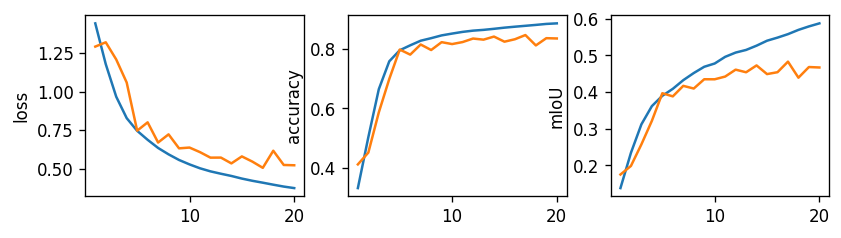

In [23]:
# Plot loss, accuracy and IoU trends in training process
plt.figure(figsize=(8, 2), dpi=120)
ylabels = ['loss', 'accuracy', 'mIoU']
x = np.arange(EPOCHS, dtype=int) + 1
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(x, train_stats[:, i], label='train')
    plt.plot(x, val_stats[:, i], label='val')
    plt.ylabel(ylabels[i])
plt.show()

## Evaluation on Test Set

In [18]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
model.eval()
conf_meter = ConfMatMeter(N_CLASSES)
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    model.eval()
    conf_meter = ConfMatMeter(N_CLASSES)
    test_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(test_loader):
        assert inputs.shape[0] == 1 # process single image at a time
        inputs, labels = inputs.to(DEVICE), labels.long().to(DEVICE)
        # compute outputs and loss
        outputs = model(inputs)
        preds = outputs.argmax(axis=1)
        loss = criterion(outputs, labels)
        # update statistics
        test_loss += loss.item() * inputs.shape[0]
        correct += (preds == labels).sum()
        total += np.prod(labels.shape)
        conf_meter.add(preds.cpu().numpy(), labels.cpu().numpy())
test_loss, test_acc = test_loss/len(test_loader), correct/total
test_iou = iou(conf_meter.conf_mat)
print('test loss: %.3f, accuracy: %.3f, mIoU: %.3f' % 
        (test_loss, test_acc, test_iou))

  0%|          | 0/4 [00:00<?, ?it/s]

test loss: 0.439, accuracy: 0.863, mIoU: 0.481


## Visualization

In [21]:
def display(display_list):
    plt.figure(figsize=(8, 8), dpi=120)
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0: plt.imshow(display_list[i], cmap='gray')
        else: plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

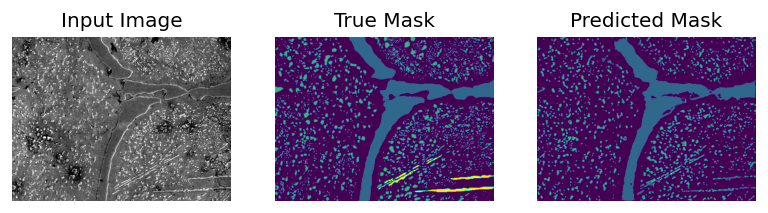

In [22]:
# Change index to visualize different images in test set
idx = 0 
img_name = test_set.img_names[idx]
img = plt.imread(f'{root}/images/{img_name}')
label = np.load(f'{root}/labels_npy/{os.path.splitext(img_name)[0]}.npy')
model.eval()
pred = model(test_set[0][0].unsqueeze(0))[0].argmax(0).detach().cpu().numpy()
display([img, label, pred])